# Packet Signature Detector

Identify potentially malicious packets by training a Naive Bayes classifier on packet payloads that include known malicious signatures (e.g., `malware`, `exploit`). The notebook is self-contained and runs on Colab, Jupyter, or VS Code with Python, pandas, numpy, matplotlib, scikit-learn, and optionally nltk.


## Workflow
1. Generate or load packet payload logs with labels (benign vs malicious).
2. Build a malicious keyword dictionary (`malware`, `exploit`, `trojan`, etc.) to enrich features.
3. Vectorize payloads and train a Multinomial Naive Bayes classifier.
4. Evaluate performance with precision/recall/F1 and visualize results.
5. Run the trained model on new packets to raise alerts when signatures are detected.


In [3]:
import random
import textwrap
from typing import List, Tuple

import matplotlib.pyplot as plt # type: ignore
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


In [4]:
random.seed(42)

MALICIOUS_KEYWORDS = [
    "malware",
    "exploit",
    "trojan",
    "botnet",
    "payload",
    "shellcode",
    "ransom",
    "phishing",
    "keylogger",
]

BENIGN_PHRASES = [
    "status update",
    "heartbeat ok",
    "user login",
    "file sync",
    "dns query",
    "cdn asset",
    "api response",
    "metrics batch",
    "system health",
]

MALICIOUS_TEMPLATES = [
    "detected {keyword} sequence in packet {id} with {size} bytes",
    "command to deploy {keyword} on port {port}",
    "{keyword} loader attempt from suspicious host",
    "suspicious payload contains {keyword} markers",
]

BENIGN_TEMPLATES = [
    "{phrase} packet {id} length {size} bytes",
    "{phrase} received from trusted subnet",
    "{phrase} broadcast on port {port}",
    "{phrase} cached successfully",
]

def synthesize_packets(n_packets: int = 120) -> pd.DataFrame:
    rows: List[Tuple[str, str, int]] = []
    for idx in range(n_packets):
        packet_id = f"pkt-{idx:03d}"
        size = random.randint(200, 2000)
        port = random.choice([22, 53, 80, 443, 8080, 8443])
        if random.random() < 0.4:
            keyword = random.choice(MALICIOUS_KEYWORDS)
            template = random.choice(MALICIOUS_TEMPLATES)
            payload = template.format(keyword=keyword, id=packet_id, size=size, port=port)
            label = "malicious"
        else:
            phrase = random.choice(BENIGN_PHRASES)
            template = random.choice(BENIGN_TEMPLATES)
            payload = template.format(phrase=phrase, id=packet_id, size=size, port=port)
            label = "benign"
        rows.append((packet_id, payload, size, port, label))
    return pd.DataFrame(rows, columns=["packet_id", "payload", "size", "port", "label"])

packets_df = synthesize_packets()
packets_df.head()


,packet_id,payload,size,port,label
0,pkt-000,command to deploy payload on port 22,1509,22,malicious
1,pkt-001,system health packet pkt-001 length 657 bytes,657,53,benign
2,pkt-002,command to deploy exploit on port 443,1409,443,malicious
3,pkt-003,system health received from trusted subnet,676,8080,benign
4,pkt-004,api response received from trusted subnet,1666,8443,benign


In [5]:
packets_df.label.value_counts(normalize=True).rename("ratio")


label
benign       0.525
malicious    0.475
Name: ratio, dtype: float64

In [6]:
def keyword_hit_rate(text: str) -> float:
    tokens = text.lower().split()
    matches = sum(token in MALICIOUS_KEYWORDS for token in tokens)
    return matches / max(len(tokens), 1)

packets_df["keyword_score"] = packets_df["payload"].map(keyword_hit_rate)

X_train, X_test, y_train, y_test = train_test_split(
    packets_df[["payload", "keyword_score"]],
    packets_df["label"],
    test_size=0.25,
    random_state=42,
    stratify=packets_df["label"],
)

preprocessor = ColumnTransformer(
    transformers=[
        ("payload", CountVectorizer(ngram_range=(1, 2), lowercase=True), "payload"),
        ("keyword_score", "passthrough", ["keyword_score"]),
    ]
)

model = Pipeline([
    ("features", preprocessor),
    ("classifier", MultinomialNB()),
])

model.fit(X_train, y_train)

fitted_vectorizer = model.named_steps["features"].named_transformers_["payload"]
print("Training complete. Vocabulary size:", len(fitted_vectorizer.vocabulary_))


Training complete. Vocabulary size: 267


              precision    recall  f1-score   support

      benign       1.00      1.00      1.00        16
   malicious       1.00      1.00      1.00        14

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



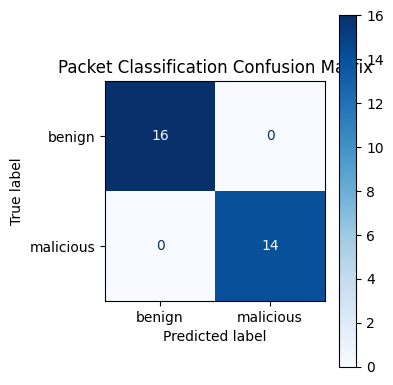

In [7]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", ax=ax)
ax.set_title("Packet Classification Confusion Matrix")
plt.tight_layout()
plt.show()


In [8]:
def detect_malicious_packets(payloads: List[str]) -> pd.DataFrame:
    temp_df = pd.DataFrame({"payload": payloads})
    temp_df["keyword_score"] = temp_df["payload"].map(keyword_hit_rate)
    temp_df["prediction"] = model.predict(temp_df)
    temp_df["malicious_probability"] = model.predict_proba(temp_df)[:, 1]
    temp_df["matched_keywords"] = temp_df["payload"].apply(
        lambda text: [kw for kw in MALICIOUS_KEYWORDS if kw in text.lower()]
    )
    return temp_df

sample_payloads = [
    "cdn asset heartbeat ok for pkt-999 length 512",
    "detected exploit payload executing shellcode",
    "metrics batch packet transmitted on port 443",
    "command issued to deploy trojan loader via port 8080",
]
alerts_df = detect_malicious_packets(sample_payloads)
alerts_df


,payload,keyword_score,prediction,malicious_probability,matched_keywords
0,cdn asset heartbeat ok for pkt-999 length 512,0.000000,benign,0.000002,[]
1,detected exploit payload executing shellcode,0.600000,malicious,0.999960,"[exploit, payload, shellcode]"
2,metrics batch packet transmitted on port 443,0.000000,malicious,0.792650,[]
3,command issued to deploy trojan loader via por...,0.111111,malicious,1.000000,[trojan]


In [9]:
alert_rows = alerts_df[alerts_df["prediction"] == "malicious"].copy()
if alert_rows.empty:
    print("No malicious signatures detected.")
else:
    for _, row in alert_rows.iterrows():
        wrapped = textwrap.fill(row["payload"], width=70)
        print(f"ALERT :: {row['malicious_probability']:.2f} probability :: {row['matched_keywords']}")
        print(wrapped)
        print("-" * 80)


ALERT :: 1.00 probability :: ['exploit', 'payload', 'shellcode']
detected exploit payload executing shellcode
--------------------------------------------------------------------------------
ALERT :: 0.79 probability :: []
metrics batch packet transmitted on port 443
--------------------------------------------------------------------------------
ALERT :: 1.00 probability :: ['trojan']
command issued to deploy trojan loader via port 8080
--------------------------------------------------------------------------------


## How to Run
1. Install dependencies: `pip install pandas numpy matplotlib scikit-learn` (nltk optional).
2. Open this notebook in Colab/Jupyter/VS Code and run cells top-to-bottom.
3. Replace `synthesize_packets` with your packet capture parser when real data is available.
4. Update `MALICIOUS_KEYWORDS` whenever new signatures are published.
5. Use `detect_malicious_packets` to score live traffic and forward any `ALERT` lines to your monitoring stack.


## Next Steps
- Replace the synthetic dataset with parsed PCAP payloads or IDS logs.
- Maintain a continuously updated keyword/signature list from threat intel feeds.
- Persist trained models or retrain nightly as new samples arrive.
- Hook alerting output into SIEM tooling or ticketing workflows.
